In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.17.2%2Bcu118-cp312-cp312-win_amd64.whl (4.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.2.2%2Bcu118-cp312-cp312-win_amd64.whl (3.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.2.2%2Bcu118-cp312-cp312-win_amd64.whl (2704.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install transformers datasets
%pip install torch==2.2.1+cu121
%pip install tensorflow

# from google.colab import drive
# drive.mount('/content/drive')

# %pip install kaggle
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'


^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==2.2.1+cu121 (from versions: 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==2.2.1+cu121


: 

: 

In [1]:
import torch

DEVICE =  "cuda: 0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda: 0'

In [2]:
from datasets import load_dataset, Dataset, Value, ClassLabel, Features

my_dataset = load_dataset("./Emotion_Dataset", sep=",")
# Creating a ClassLabel Object
df = my_dataset["train"].to_pandas()
labels = ['sadness','joy','love','anger', 'fear', 'surprise']
ClassLabels = ClassLabel(num_classes=len(labels), names=labels)

# Mapping Labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

my_dataset= my_dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
my_dataset = my_dataset.cast_column('label', ClassLabels)

my_dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
X_train = my_dataset["train"].to_pandas()
X_val = my_dataset["validation"].to_pandas()
X_test = my_dataset["test"].to_pandas()
y_true = X_test.label
y_true

0       0
1       0
2       0
3       1
4       0
       ..
1995    3
1996    3
1997    1
1998    1
1999    4
Name: label, Length: 2000, dtype: int64

In [7]:
features = my_dataset["train"].features
features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
features["label"].int2str(0)

'sadness'

In [9]:
id2label = {idx:features["label"].int2str(idx) for idx in range(6)}
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [10]:
label2id = {v:k for k,v in id2label.items()}
label2id

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [11]:
X_train["label"].value_counts(normalize=True).sort_index()

label
0    0.291625
1    0.335125
2    0.081500
3    0.134937
4    0.121063
5    0.035750
Name: proportion, dtype: float64

In [12]:
from transformers import AutoTokenizer

model_ckpt = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
tokenizer(my_dataset["train"]["text"][:1])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}

In [14]:
def tokenize_text(examples):
  return tokenizer(examples["text"], truncation=True, max_length=512)


In [15]:
my_dataset = my_dataset.map(tokenize_text, batched=True)
my_dataset

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [16]:
class_weights = (1 - (X_train["label"].value_counts().sort_index() / len(X_train))).values #assigning high weight to the rare classes and low weight to the common classes to balance it out as there is an imbalance in the dataset
class_weights

import torch

class_weights = torch.from_numpy(class_weights).float()
class_weights = class_weights.to("cuda")
class_weights

tensor([0.7084, 0.6649, 0.9185, 0.8651, 0.8789, 0.9643], device='cuda:0')

In [17]:
my_dataset = my_dataset.rename_column("label", "labels")

In [18]:
from torch import nn
import torch
from transformers import Trainer

class WeightedLossTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # Feed inputs to model and extract logits
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # Extract labels
    labels = inputs.get("labels")
    #Define loss function with class weights
    loss_func=nn.CrossEntropyLoss(weight=class_weights)
    # Compute loss
    loss = loss_func(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [25]:
from transformers import AutoModelForSequenceClassification, BertConfig, TextClassificationPipeline

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                          num_labels=6,
                                                          id2label=id2label,
                                                          label2id=label2id)
# config = BertConfig.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')

# model = AutoModelForSequenceClassification.from_pretrained(config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  accuracy= accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  return {"f1": f1, "accuracy" : accuracy}


In [41]:
%pip install transformers[torch]
%pip install accelerate -U
from transformers import TrainingArguments

batch_size = 64

logging_steps = len(my_dataset["train"])
output_dir = "./best_model_miniLM"
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  fp16=True,
                                  )


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
trainer = WeightedLossTrainer(model=model,
                              args=training_args,
                              compute_metrics=compute_metrics,
                              train_dataset=my_dataset["train"],
                              eval_dataset=my_dataset["validation"],
                              tokenizer=tokenizer)

c:\Users\alice\Documents\Final year project\Fyp_code\.venv\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [43]:
from transformers import pipeline
from tqdm import tqdm
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

In [44]:
def predict(model, tokenizer):
    y_pred = []
    none_pred = []
    for i in tqdm(range(len(X_test))):
        # prompt = X_test.iloc[i]["text"].to(DEVICE)
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-classification",
                        model=model,
                        tokenizer=tokenizer,
                       )
        result = pipe(prompt)
        answer = result[0]['label'].split("=")[-1]
        #print(result)
        #print(answer)
        if "sadness" in answer:
            y_pred.append(0)
        elif "joy" in answer:
            y_pred.append(1)
        elif "love" in answer:
            y_pred.append(2)
        elif "anger" in answer:
            y_pred.append(3)
        elif "fear" in answer:
            y_pred.append(4)
        elif "surprise" in answer:
            y_pred.append(5)
        else:
            y_pred.append(6)
            none_pred.append(answer)
        # print(none_pred)
    return y_pred, none_pred

In [45]:
def evaluate(y_true, y_pred):

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels output: {0,1,2,3,4,5}

    # nested for loops
    for label in unique_labels:
        # will output a list of the index of one emotion at a time
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        # will output the list of one emotion
        label_y_true = [y_true[i] for i in label_indices]
        # label_y_true = [label for i in range(len(y_true))]
        # will output list of the predicted emotion in the same order as label_y_true
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [48]:
y_pred, none_pred = predict(model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 2000/2000 [00:45<00:00, 43.65it/s]

Accuracy: 0.379
Accuracy for label 0: 0.293
Accuracy for label 1: 0.845
Accuracy for label 2: 0.000
Accuracy for label 3: 0.000
Accuracy for label 4: 0.000
Accuracy for label 5: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.29      0.32       581
           1       0.39      0.84      0.53       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       224
           5       0.00      0.00      0.00        66

    accuracy                           0.38      2000
   macro avg       0.12      0.19      0.14      2000
weighted avg       0.24      0.38      0.28      2000


Confusion Matrix:
[[170 411   0   0   0   0   0]
 [108 587   0   0   0   0   0]
 [ 35 124   0   0   0   0   0]
 [ 81 194   0   0   0   0   0]
 [ 64 160   0   0   0   0   0]
 [ 24  42   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]



c:\Users\alice\Documents\Final year project\Fyp_code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alice\Documents\Final year project\Fyp_code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alice\Documents\Final year project\Fyp_code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [49]:
model.train() #changing the setting for training
trainer.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.9352469444274902, 'eval_f1': 0.6381954854137055, 'eval_accuracy': 0.712, 'eval_runtime': 23.5391, 'eval_samples_per_second': 84.965, 'eval_steps_per_second': 1.359, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.583864688873291, 'eval_f1': 0.8724194317417845, 'eval_accuracy': 0.8795, 'eval_runtime': 23.4405, 'eval_samples_per_second': 85.322, 'eval_steps_per_second': 1.365, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4398213028907776, 'eval_f1': 0.9096946795661796, 'eval_accuracy': 0.909, 'eval_runtime': 23.4175, 'eval_samples_per_second': 85.406, 'eval_steps_per_second': 1.367, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3566077947616577, 'eval_f1': 0.920261606090851, 'eval_accuracy': 0.9195, 'eval_runtime': 23.3771, 'eval_samples_per_second': 85.554, 'eval_steps_per_second': 1.369, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.33707958459854126, 'eval_f1': 0.919458250538702, 'eval_accuracy': 0.9185, 'eval_runtime': 23.2541, 'eval_samples_per_second': 86.006, 'eval_steps_per_second': 1.376, 'epoch': 5.0}
{'train_runtime': 1408.8044, 'train_samples_per_second': 56.786, 'train_steps_per_second': 0.887, 'train_loss': 0.6625689453125, 'epoch': 5.0}


TrainOutput(global_step=1250, training_loss=0.6625689453125, metrics={'train_runtime': 1408.8044, 'train_samples_per_second': 56.786, 'train_steps_per_second': 0.887, 'train_loss': 0.6625689453125, 'epoch': 5.0})

In [ ]:
model.eval() #changing the setting for testing
pred = trainer.predict(my_dataset["test"])
pred

  0%|          | 0/32 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 3.5019531 , -0.6020508 , -1.1777344 ,  0.1829834 , -0.9506836 ,
        -1.0439453 ],
       [ 3.5039062 , -0.6230469 , -1.1826172 ,  0.18188477, -0.94140625,
        -1.0253906 ],
       [ 3.4921875 , -0.69091797, -1.1669922 ,  0.15014648, -0.8881836 ,
        -0.9707031 ],
       ...,
       [-0.57910156,  3.6835938 ,  0.5600586 , -1.3583984 , -1.5244141 ,
        -0.86376953],
       [-0.6220703 ,  3.6679688 ,  0.5229492 , -1.3925781 , -1.4189453 ,
        -0.8286133 ],
       [-1.1816406 , -1.4697266 , -0.24572754, -0.70214844,  2.1386719 ,
         1.8916016 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 4], dtype=int64), metrics={'test_loss': 0.3069058954715729, 'test_f1': 0.9194852777281491, 'test_accuracy': 0.9175, 'test_runtime': 10.224, 'test_samples_per_second': 195.618, 'test_steps_per_second': 3.13})

In [ ]:
trainer.evaluate(my_dataset["test"])

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3069058954715729,
 'eval_f1': 0.9194852777281491,
 'eval_accuracy': 0.9175,
 'eval_runtime': 10.4452,
 'eval_samples_per_second': 191.476,
 'eval_steps_per_second': 3.064,
 'epoch': 6.0}

In [60]:
y_pred, none_pred = predict(model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 2000/2000 [00:43<00:00, 46.35it/s]

Accuracy: 0.914
Accuracy for label 0: 0.947
Accuracy for label 1: 0.909
Accuracy for label 2: 0.969
Accuracy for label 3: 0.905
Accuracy for label 4: 0.902
Accuracy for label 5: 0.621

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       581
           1       0.97      0.91      0.94       695
           2       0.71      0.97      0.82       159
           3       0.92      0.91      0.91       275
           4       0.87      0.90      0.88       224
           5       0.77      0.62      0.69        66

    accuracy                           0.91      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.91      0.92      2000


Confusion Matrix:
[[550   9   0  14   8   0   0]
 [  4 632  54   5   0   0   0]
 [  0   5 154   0   0   0   0]
 [ 11   4   0 249  11   0   0]
 [  6   0   0   4 202  12   0]
 [  3   0  10   0  12  41   0]
 [  0   0   0   0   0   0   0]]


In [117]:
prompt = "I cannot wait to go home."
pipe = pipeline(task="text-classification",
        model=model,
        tokenizer=tokenizer,
        return_all_scores=True,
        )
a_result = pipe(prompt)
a_result

[[{'label': 'sadness', 'score': 0.2602122724056244},
  {'label': 'joy', 'score': 0.19430160522460938},
  {'label': 'love', 'score': 0.020780444145202637},
  {'label': 'anger', 'score': 0.35773766040802},
  {'label': 'fear', 'score': 0.14316889643669128},
  {'label': 'surprise', 'score': 0.023799188435077667}]]

In [77]:
for i in a_result[0]:
    print(i["score"])

0.02344273030757904
0.9093142151832581
0.03853796049952507
0.016722165048122406
0.003947991877794266
0.008035006932914257


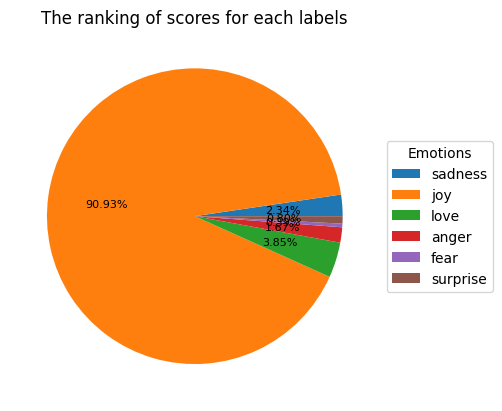

In [115]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

emotions = [i["label"] for i in a_result[0]]
scores = [i["score"] for i in a_result[0]]
bar_colors = ['tab:blue']

# ax.bar(emotions, scores, color=bar_colors)
wedges, texts, autotexts = ax.pie(scores,
                               autopct="%1.2f%%",
                               textprops={'fontsize':8},)

#for autotext in autotexts:
    #autotext.set_family('cursive')
    #autotext.set_rotation(180)

ax.legend(wedges, emotions,
          title="Emotions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('The ranking of scores for each labels')

plt.savefig('I_am_happy.png')
plt.show()